In [64]:
%pip install --quiet geopandas
%pip install --quiet --no-deps "git+https://github.com/uba/tathu.git"
%pip install -q scikit-image scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [65]:
!pip install arm-pyart==1.19.0 xarray-datatree==0.0.14 xarray==2024.9.0

In [66]:
import pyart
import glob
from skimage import morphology
from collections import defaultdict
from skimage import measure
from scipy.optimize import linear_sum_assignment

In [92]:
#####################################################################################################
dato_radar_inicial="datos/RMA1_0303_01_20241128T214436Z.nc"
dato_radar_current_1="datos/RMA1_0303_01_20241128T215736Z.nc"
dato_radar_current_2="datos/RMA1_0303_01_20241128T221036Z.nc"
dato_radar_current_3="datos/RMA1_0303_01_20241128T222336Z.nc"
dato_radar_current_4 = "datos/RMA1_0303_01_20241128T224936Z.nc"

#####################################################################################################
dato_radar_inicial = pyart.io.read(dato_radar_inicial)
dato_radar_current_1 = pyart.io.read(dato_radar_current_1)
dato_radar_current_2 = pyart.io.read(dato_radar_current_2)
dato_radar_current_3 = pyart.io.read(dato_radar_current_3)
dato_radar_current_4 = pyart.io.read(dato_radar_current_4)

#####################################################################################################

In [93]:
## CREAMOS EL SYSTEMS PARA EL PRIMER DATO DE RADAR
from pyart.map import grid_from_radars
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_inicial = grid_from_radars(
    (dato_radar_inicial,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
### AHORA HACEMOs LO MISMO PARA EL SEGUNDO DATO DE RADAR #################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_current_1 = grid_from_radars(
    (dato_radar_current_1,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_2 = grid_from_radars(
    (dato_radar_current_2,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_3 = grid_from_radars(
    (dato_radar_current_3,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])

### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_4 = grid_from_radars(
    (dato_radar_current_4,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])



In [94]:
#### ESTA FUNCIóN PERMITE GRAFICAR EN UNA MISMA FILA LOS SISTEMAS de DIFERENTES datos ##########################
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from skimage import measure
import scipy.ndimage as ndi
from matplotlib.colors import ListedColormap

def detectar_sistemas_convectivos_visual(grid, nivel=1, umbral_dbz=35, min_area_km2=80,
                                   extent_km=200, plot=True, return_axes=False, return_mask=False):

    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    binary = dbz_slice > umbral_dbz
    labeled_array, num_features = ndi.label(binary)
    areas = ndi.sum(binary, labeled_array, index=np.arange(1, num_features+1))

    pixel_spacing_km = extent_km / labeled_array.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    valid_labels = [i+1 for i, area in enumerate(areas) if area * pixel_area_km2 >= min_area_km2]
    mask = np.isin(labeled_array, valid_labels)

    fig, ax = None, None
    if (plot or return_axes) and np.any(mask):
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = ListedColormap(['white', 'black'])
        im = ax.imshow(mask, cmap=cmap, origin='lower')
        ax.set_title(f'Sistemas detectados - nivel {nivel} ({grid.z["data"][nivel]:.0f} m)')
        fig.colorbar(im, ax=ax)
        ax.grid(True)
        if plot:
            plt.show()

    # Extraer contornos y atributos
    x_min = -extent_km / 2
    y_min = -extent_km / 2
    systems = []

    for label in valid_labels:
        region_mask = labeled_array == label
        contours = measure.find_contours(region_mask, 0.5)
        if not contours:
            continue
        contour = max(contours, key=len)
        row = contour[:, 0]
        col = contour[:, 1]
        x = x_min + col * pixel_spacing_km
        y = y_min + row * pixel_spacing_km
        poly = Polygon(zip(x, y))
        if not poly.is_valid or poly.area == 0:
            continue
        systems.append({
            'id': label,
            'geometry': poly,
            'centroid': poly.centroid,
            'area_km2': poly.area,
            'max_dbz': np.max(dbz_slice[region_mask]),
            'mean_dbz': np.mean(dbz_slice[region_mask])
        })

    # retorno
    if return_axes:
        return systems, fig, ax
    elif return_mask:
        return systems, mask
    else:
        return systems


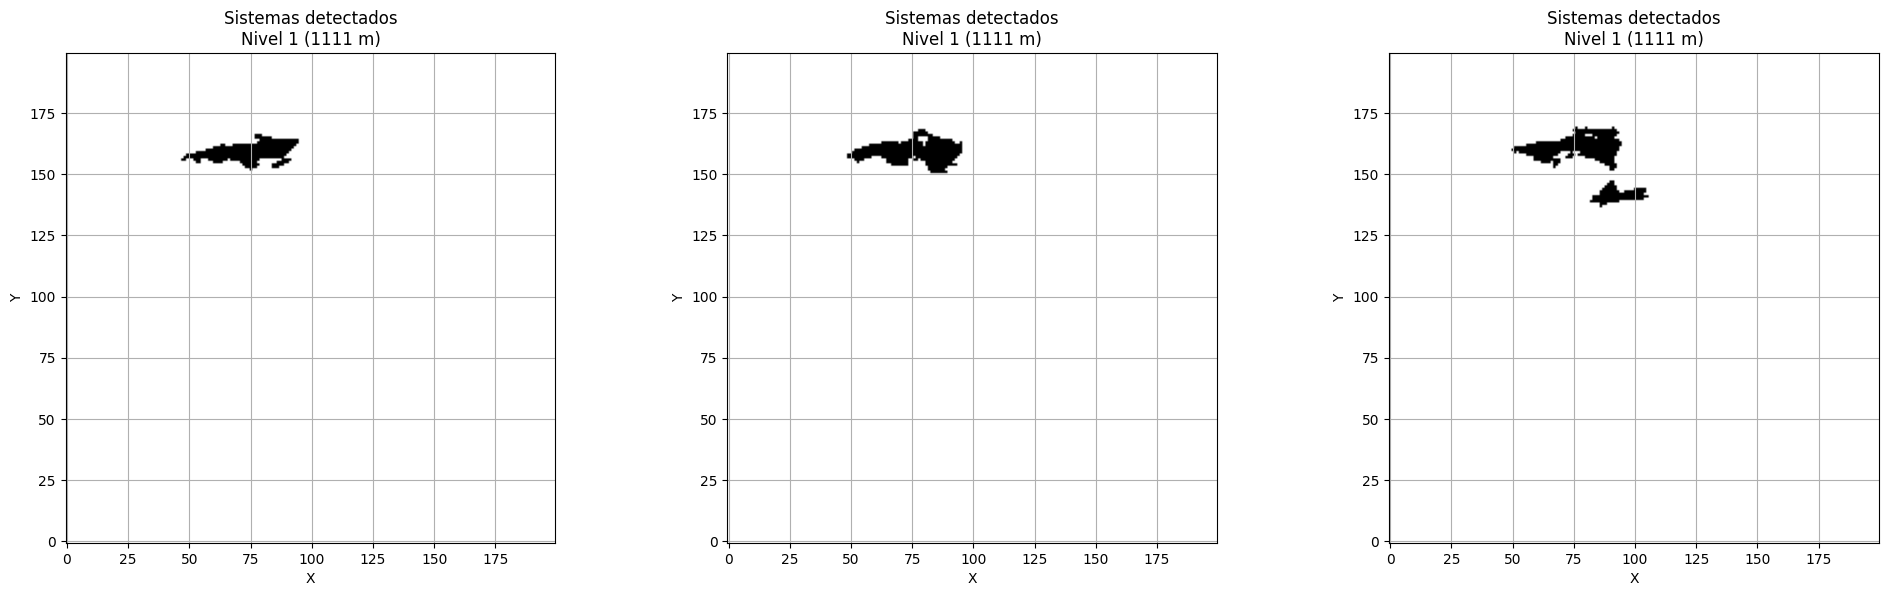

In [98]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
grids = [grid_inicial, grid_current_1, grid_current_2]

for i, grid in enumerate(grids):
    systems, mask = detectar_sistemas_convectivos_visual(grid, nivel=1, umbral_dbz=30,
                                                   min_area_km2=100, extent_km=200,
                                                   plot=False, return_mask=True)

    axs[i].imshow(mask, cmap=ListedColormap(['white', 'black']), origin='lower')
    axs[i].set_title(f"Sistemas detectados\nNivel 1 ({grid.z['data'][1]:.0f} m)")
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [99]:
################################################################################
# FASE 1: IDENTIFICACIÓN MULTI-UMBRAL CON MORFOLOGÍA MATEMÁTICA
################################################################################

def detectar_sistemas_etitan(grid, nivel=0, umbrales_dbz=[35, 40, 45, 50], 
                             min_area_km2=100, extent_km=200, plot=False):
    """
    Identificación de sistemas convectivos usando método multi-umbral ETITAN.
    
    Mejora sobre TITAN: usa múltiples umbrales para separar células 
    adyacentes que se fusionan falsamente con un solo umbral.
    
    Parameters:
    -----------
    grid : PyART grid object
    nivel : int, nivel vertical a analizar
    umbrales_dbz : list, umbrales de reflectividad en orden ascendente
    min_area_km2 : float, área mínima para considerar un sistema
    extent_km : float, extensión espacial del dominio
    plot : bool, visualizar resultados
    
    Returns:
    --------
    systems : list de diccionarios con sistemas identificados
    """
    
    # 1. Extraer reflectividad
    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    pixel_spacing_km = extent_km / dbz_slice.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    
    # 2. Identificación multi-umbral con morfología
    systems_multi = []
    
    for i, umbral in enumerate(umbrales_dbz):
        # 2a. Umbralización
        binary = dbz_slice > umbral
        
        # 2b. Operaciones morfológicas para separar células fusionadas
        if i > 0:
            # Erosión: reduce regiones, separa células conectadas débilmente
            struct = morphology.disk(1)  # elemento estructurante
            binary = morphology.binary_erosion(binary, struct)
        
        # 2c. Etiquetado de componentes
        labeled_array, num_features = ndi.label(binary)
        
        # 2d. Filtro por área
        for label in range(1, num_features + 1):
            mask = labeled_array == label
            area_pixels = np.sum(mask)
            area_km2 = area_pixels * pixel_area_km2
            
            if area_km2 >= min_area_km2:
                # 2e. Dilatación para recuperar tamaño original (si hubo erosión)
                if i > 0:
                    mask_dilated = morphology.binary_dilation(mask, struct)
                    # Intersección con umbral original para no crecer demasiado
                    mask = mask_dilated & (dbz_slice > umbral)
                
                # 2f. Extraer contorno y geometría
                contours = measure.find_contours(mask.astype(float), 0.5)
                if not contours:
                    continue
                
                contour = max(contours, key=len)
                x_min = -extent_km / 2
                y_min = -extent_km / 2
                
                row = contour[:, 0]
                col = contour[:, 1]
                x = x_min + col * pixel_spacing_km
                y = y_min + row * pixel_spacing_km
                
                poly = Polygon(zip(x, y))
                if not poly.is_valid or poly.area == 0:
                    continue
                
                # 2g. Calcular atributos
                centroid = poly.centroid
                max_dbz = np.max(dbz_slice[mask])
                mean_dbz = np.mean(dbz_slice[mask])
                
                systems_multi.append({
                    'id': len(systems_multi) + 1,
                    'threshold_level': i,
                    'threshold_dbz': umbral,
                    'geometry': poly,
                    'centroid': centroid,
                    'area_km2': poly.area,
                    'max_dbz': max_dbz,
                    'mean_dbz': mean_dbz,
                    'mask': mask
                })
    
    # 3. Fusionar núcleos de diferentes umbrales que pertenecen al mismo sistema
    systems_final = fusionar_nucleos_multiumbral(systems_multi)
    
    # 4. Visualización
    if plot:
        visualizar_deteccion_multiumbral(dbz_slice, systems_multi, systems_final, 
                                        umbrales_dbz, extent_km, nivel, grid)
    
    return systems_final

In [100]:
################################################################################
# FASE 2: TRACKING CON RESTRICCIONES DINÁMICAS
################################################################################

def tracking_etitan(systems_old, systems_new, max_distance_km=20, 
                   velocity_history=None, dt_minutes=5):
    """
    Tracking con optimización combinatoria y restricciones dinámicas (ETITAN).
    
    Mejoras sobre tracking simple:
    - Usa overlapping (superposición de geometrías)
    - Restricción dinámica de velocidad basada en historial
    - Considera características físicas adicionales
    
    Parameters:
    -----------
    systems_old : list, sistemas en tiempo t
    systems_new : list, sistemas en tiempo t+1
    max_distance_km : float, distancia máxima base
    velocity_history : dict, {system_id: (vx, vy)} velocidades previas
    dt_minutes : float, intervalo temporal en minutos
    
    Returns:
    --------
    matches : list de diccionarios con correspondencias
    """
    
    n_old = len(systems_old)
    n_new = len(systems_new)
    
    if n_old == 0 or n_new == 0:
        return []
    
    # 1. Construir matriz de costos multi-criterio
    cost_matrix = np.full((n_old, n_new), np.inf)
    
    for i, old in enumerate(systems_old):
        # Restricción dinámica de velocidad
        if velocity_history and old['id'] in velocity_history:
            vx, vy = velocity_history[old['id']]
            v_mag = np.sqrt(vx**2 + vy**2)
            # Permitir 50% de variación sobre velocidad histórica
            max_dist_dynamic = max(max_distance_km, v_mag * dt_minutes/60 * 1.5)
        else:
            max_dist_dynamic = max_distance_km
        
        old_centroid = np.array([old['centroid'].x, old['centroid'].y])
        
        for j, new in enumerate(systems_new):
            new_centroid = np.array([new['centroid'].x, new['centroid'].y])
            
            # A. Distancia de centroides
            distance = np.linalg.norm(old_centroid - new_centroid)
            
            if distance > max_dist_dynamic:
                continue  # Fuera del rango dinámico
            
            # B. Superposición geométrica (técnica de overlapping)
            try:
                intersection = old['geometry'].intersection(new['geometry'])
                union = old['geometry'].union(new['geometry'])
                overlap_ratio = intersection.area / union.area if union.area > 0 else 0
            except:
                overlap_ratio = 0
            
            # C. Similitud de área
            area_diff = abs(new['area_km2'] - old['area_km2'])
            area_mean = (new['area_km2'] + old['area_km2']) / 2
            area_similarity = 1 - min(area_diff / area_mean, 1.0)
            
            # D. Similitud de intensidad
            dbz_diff = abs(new['max_dbz'] - old['max_dbz'])
            dbz_similarity = 1 - min(dbz_diff / 20.0, 1.0)
            
            # E. Costo combinado (pesos ajustables)
            w_dist = 0.4
            w_overlap = 0.3
            w_area = 0.2
            w_dbz = 0.1
            
            cost = (w_dist * (distance / max_dist_dynamic) + 
                   w_overlap * (1 - overlap_ratio) +
                   w_area * (1 - area_similarity) +
                   w_dbz * (1 - dbz_similarity))
            
            cost_matrix[i, j] = cost
    
    # 2. Resolver asignación óptima con algoritmo húngaro
    filas_validas = ~np.all(np.isinf(cost_matrix), axis=1)
    columnas_validas = ~np.all(np.isinf(cost_matrix), axis=0)
    
    if not np.any(filas_validas) or not np.any(columnas_validas):
        return []
    
    submatrix = cost_matrix[np.ix_(filas_validas, columnas_validas)]
    row_sub, col_sub = linear_sum_assignment(submatrix)
    
    row_ind = np.where(filas_validas)[0][row_sub]
    col_ind = np.where(columnas_validas)[0][col_sub]
    
    # 3. Construir matches
    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] != np.inf:
            old_centroid = np.array([systems_old[i]['centroid'].x,
                                    systems_old[i]['centroid'].y])
            new_centroid = np.array([systems_new[j]['centroid'].x,
                                    systems_new[j]['centroid'].y])
            
            distance = np.linalg.norm(old_centroid - new_centroid)
            
            # Calcular velocidad
            vx = (new_centroid[0] - old_centroid[0]) / (dt_minutes / 60)
            vy = (new_centroid[1] - old_centroid[1]) / (dt_minutes / 60)
            
            matches.append({
                'old_id': systems_old[i]['id'],
                'new_id': systems_new[j]['id'],
                'distance_km': distance,
                'velocity_x': vx,
                'velocity_y': vy,
                'velocity_mag': np.sqrt(vx**2 + vy**2),
                'cost': cost_matrix[i, j]
            })
    
    return matches

In [73]:
def fusionar_nucleos_multiumbral(systems_multi):
    """
    Fusiona núcleos de diferentes umbrales que pertenecen al mismo sistema.
    Un núcleo de mayor umbral contenido en uno de menor umbral se considera
    parte del mismo sistema.
    """
    if not systems_multi:
        return []
    
    # Ordenar por umbral (mayor a menor) y área (mayor a menor)
    systems_sorted = sorted(systems_multi, 
                           key=lambda x: (-x['threshold_level'], -x['area_km2']))
    
    systems_final = []
    used_systems = set()
    
    for sys in systems_sorted:
        if sys['id'] in used_systems:
            continue
        
        # Sistema base (mayor umbral, mayor área)
        system_base = {
            'id': len(systems_final) + 1,
            'geometry': sys['geometry'],
            'centroid': sys['centroid'],
            'area_km2': sys['area_km2'],
            'max_dbz': sys['max_dbz'],
            'mean_dbz': sys['mean_dbz'],
            'cores': [sys]  # Núcleos de alta reflectividad
        }
        
        # Buscar núcleos relacionados de mayor umbral
        for other in systems_sorted:
            if other['id'] in used_systems or other['id'] == sys['id']:
                continue
            
            # Si el núcleo está contenido, agregarlo
            if other['threshold_level'] > sys['threshold_level']:
                if sys['geometry'].contains(other['centroid']):
                    system_base['cores'].append(other)
                    system_base['max_dbz'] = max(system_base['max_dbz'], 
                                                 other['max_dbz'])
                    used_systems.add(other['id'])
        
        systems_final.append(system_base)
        used_systems.add(sys['id'])
    
    return systems_final

In [74]:
################################################################################
# FASE 3: PRONÓSTICO CON OPTICAL FLOW (CORRELACIÓN CRUZADA)
################################################################################

def pronosticar_posiciones_etitan(systems_current, velocity_history, 
                                  forecast_minutes=10):
    """
    Pronóstico de posiciones futuras usando vectores de movimiento.
    
    ETITAN usa el campo de vectores calculado por correlación cruzada.
    Aquí usamos las velocidades del tracking.
    
    Parameters:
    -----------
    systems_current : list, sistemas actuales
    velocity_history : dict, {system_id: (vx, vy)}
    forecast_minutes : int, tiempo de pronóstico en minutos
    
    Returns:
    --------
    systems_forecast : list con posiciones pronosticadas
    """
    
    systems_forecast = []
    dt_hours = forecast_minutes / 60
    
    for sys in systems_current:
        if sys['id'] not in velocity_history:
            continue
        
        vx, vy = velocity_history[sys['id']]
        
        # Pronóstico de centroide
        x_forecast = sys['centroid'].x + vx * dt_hours
        y_forecast = sys['centroid'].y + vy * dt_hours
        
        # Pronóstico de geometría (traslación)
        from shapely import affinity
        geometry_forecast = affinity.translate(sys['geometry'], 
                                              xoff=vx * dt_hours,
                                              yoff=vy * dt_hours)
        
        systems_forecast.append({
            'id': sys['id'],
            'geometry': geometry_forecast,
            'centroid': Point(x_forecast, y_forecast),
            'area_km2': sys['area_km2'],
            'max_dbz': sys['max_dbz'],
            'mean_dbz': sys['mean_dbz'],
            'velocity_x': vx,
            'velocity_y': vy,
            'forecast_time_min': forecast_minutes
        })
    
    return systems_forecast


In [75]:
################################################################################
# UTILIDADES
################################################################################

def construir_trayectorias_etitan(lista_sistemas, lista_matches):
    """
    Construye trayectorias completas a partir de matches secuenciales.
    
    Parameters:
    -----------
    lista_sistemas : list de listas, [[sys_t0], [sys_t1], [sys_t2], ...]
    lista_matches : list de listas, [[matches_0_1], [matches_1_2], ...]
    
    Returns:
    --------
    trajectories : dict, {traj_id: [system_info_t0, system_info_t1, ...]}
    """
    
    trajectories = defaultdict(list)
    system_to_traj = {}  # Mapeo system_id -> trajectory_id
    next_traj_id = 1
    
    # Inicializar con sistemas del primer tiempo
    for sys in lista_sistemas[0]:
        system_to_traj[('t0', sys['id'])] = next_traj_id
        trajectories[next_traj_id].append({
            'time_step': 0,
            'system': sys
        })
        next_traj_id += 1
    
    # Propagar a través de los matches
    for t, matches in enumerate(lista_matches):
        for match in matches:
            old_key = (f't{t}', match['old_id'])
            
            if old_key in system_to_traj:
                traj_id = system_to_traj[old_key]
                new_key = (f't{t+1}', match['new_id'])
                system_to_traj[new_key] = traj_id
                
                # Encontrar sistema correspondiente
                for sys in lista_sistemas[t+1]:
                    if sys['id'] == match['new_id']:
                        trajectories[traj_id].append({
                            'time_step': t+1,
                            'system': sys,
                            'velocity': (match['velocity_x'], match['velocity_y'])
                        })
                        break
        
        # Sistemas nuevos no mapeados (nuevas trayectorias)
        matched_new_ids = {m['new_id'] for m in matches}
        for sys in lista_sistemas[t+1]:
            new_key = (f't{t+1}', sys['id'])
            if new_key not in system_to_traj:
                system_to_traj[new_key] = next_traj_id
                trajectories[next_traj_id].append({
                    'time_step': t+1,
                    'system': sys
                })
                next_traj_id += 1
    
    return dict(trajectories)

In [76]:
def actualizar_velocidad_history(velocity_history, matches):
    """
    Actualiza el historial de velocidades con los nuevos matches.
    """
    if velocity_history is None:
        velocity_history = {}
    
    for match in matches:
        velocity_history[match['new_id']] = (match['velocity_x'], 
                                            match['velocity_y'])
    
    return velocity_history

In [77]:
def visualizar_deteccion_multiumbral(dbz_slice, systems_multi, systems_final,
                                    umbrales_dbz, extent_km, nivel, grid):
    """Visualiza resultados de detección multi-umbral."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Panel 1: Todos los núcleos detectados
    ax = axes[0]
    im = ax.imshow(dbz_slice, cmap='pyart_NWSRef', origin='lower',
                   extent=[-extent_km/2, extent_km/2, -extent_km/2, extent_km/2],
                   vmin=0, vmax=70)
    
    colors = ['red', 'orange', 'yellow', 'white']
    for sys in systems_multi:
        color = colors[min(sys['threshold_level'], len(colors)-1)]
        x, y = sys['geometry'].exterior.xy
        ax.plot(x, y, color=color, linewidth=2, alpha=0.7,
               label=f"≥{sys['threshold_dbz']} dBZ" if sys['threshold_level'] < 4 else "")
    
    ax.set_title(f'Núcleos Multi-Umbral - Nivel {nivel}')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.colorbar(im, ax=ax, label='Reflectividad (dBZ)')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Sistemas finales fusionados
    ax = axes[1]
    im = ax.imshow(dbz_slice, cmap='pyart_NWSRef', origin='lower',
                   extent=[-extent_km/2, extent_km/2, -extent_km/2, extent_km/2],
                   vmin=0, vmax=70)
    
    for i, sys in enumerate(systems_final):
        x, y = sys['geometry'].exterior.xy
        ax.plot(x, y, color='cyan', linewidth=3)
        ax.plot(sys['centroid'].x, sys['centroid'].y, 'r*', markersize=15)
        ax.text(sys['centroid'].x, sys['centroid'].y, f"S{sys['id']}",
               color='white', fontsize=12, weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        # Mostrar núcleos internos
        for core in sys['cores']:
            if core['threshold_level'] > 0:
                xc, yc = core['geometry'].exterior.xy
                ax.plot(xc, yc, 'yellow', linewidth=1, linestyle='--', alpha=0.5)
    
    ax.set_title(f'Sistemas Finales (n={len(systems_final)})')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.colorbar(im, ax=ax, label='Reflectividad (dBZ)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

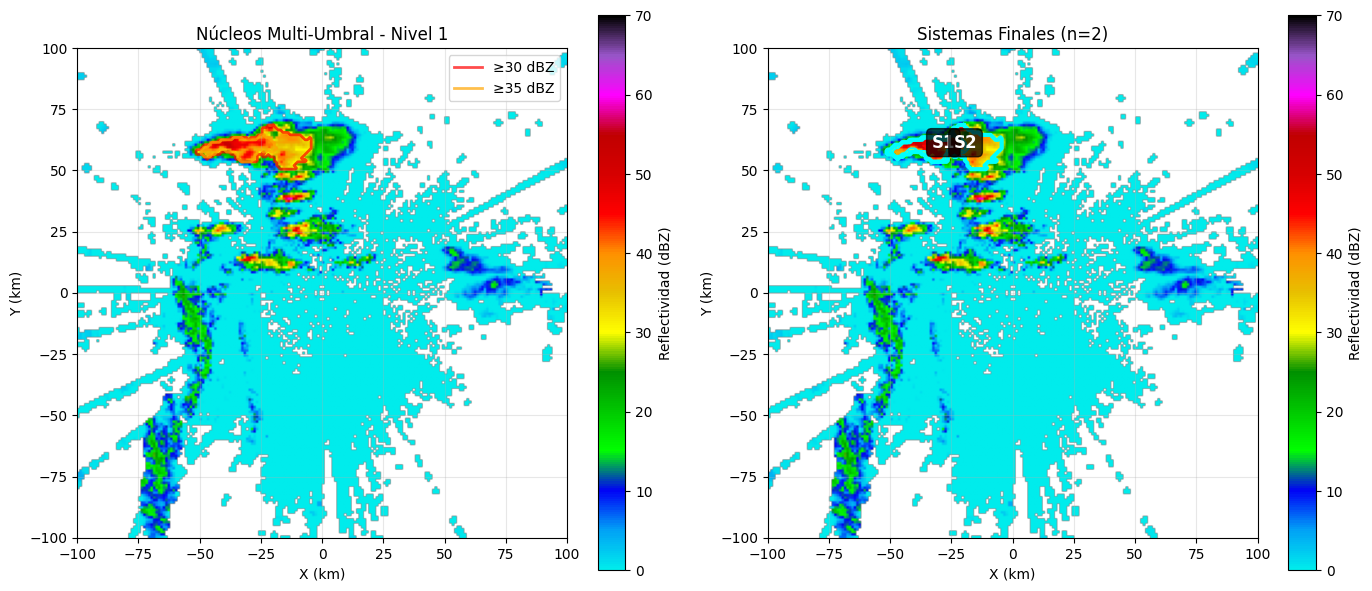

Total de trayectorias detectadas: 3

Trayectoria 1: 3 pasos temporales
  t=0: pos=(-33.1, 59.3) km, max_dbz=54.1 dBZ, área=175.5 km²
  t=1: pos=(-26.5, 60.7) km, max_dbz=50.9 dBZ, área=234.5 km², velocidad=80.5 km/h
  t=2: pos=(-32.5, 60.6) km, max_dbz=49.1 dBZ, área=118.5 km², velocidad=71.4 km/h

Trayectoria 2: 3 pasos temporales
  t=0: pos=(-24.1, 59.2) km, max_dbz=54.1 dBZ, área=421.5 km²
  t=1: pos=(-23.5, 61.1) km, max_dbz=50.9 dBZ, área=395.5 km², velocidad=23.3 km/h
  t=2: pos=(-25.4, 61.1) km, max_dbz=49.1 dBZ, área=306.5 km², velocidad=22.5 km/h

Trayectoria 3: 2 pasos temporales
  t=1: pos=(-7.1, 41.6) km, max_dbz=52.2 dBZ, área=115.5 km²
  t=2: pos=(-3.7, 41.9) km, max_dbz=54.8 dBZ, área=127.5 km², velocidad=40.8 km/h



In [119]:
# 1. DETECCIÓN con ETITAN multi-umbral
systems_t0 = detectar_sistemas_etitan(
    grid_current_1, nivel=1, 
    umbrales_dbz=[30, 35, 40, 45],
    min_area_km2=50, extent_km=200, plot=True
)

systems_t1 = detectar_sistemas_etitan(
    grid_current_2, nivel=1,
    umbrales_dbz=[30, 35, 40, 45],
    min_area_km2=50, extent_km=200, plot=False
)

systems_t2 = detectar_sistemas_etitan(
   grid_current_3, nivel=1,
   umbrales_dbz=[30, 35, 40, 45],
   min_area_km2=50, extent_km=200, plot=False
)

systems_t3 = detectar_sistemas_etitan(
    grid_current_4, nivel=1,
    umbrales_dbz=[30, 35, 40, 45],
    min_area_km2=50, extent_km=200, plot=False
)



# 2. TRACKING con restricciones dinámicas
velocity_history = {}

# Match t0 → t1
matches_0_1 = tracking_etitan(
    systems_t0, systems_t1, 
    max_distance_km=20,
    velocity_history=velocity_history,
    dt_minutes=5
)
velocity_history = actualizar_velocidad_history(velocity_history, matches_0_1)

# Match t1 → t2 
matches_1_2 = tracking_etitan(
    systems_t1, systems_t2, 
    max_distance_km=20,
    velocity_history=velocity_history,
    dt_minutes=5
)
velocity_history = actualizar_velocidad_history(velocity_history, matches_1_2)

# 3. PRONÓSTICO
systems_forecast = pronosticar_posiciones_etitan(
    systems_t2,  # Último tiempo disponible
    velocity_history,
    forecast_minutes=10
)

# 4. CONSTRUIR TRAYECTORIAS COMPLETAS
lista_sistemas = [systems_t0, systems_t1, systems_t2]
lista_matches = [matches_0_1, matches_1_2]
trajectories = construir_trayectorias_etitan(lista_sistemas, lista_matches)

# 5. ANÁLISIS
print(f"Total de trayectorias detectadas: {len(trajectories)}\n")

for traj_id, traj_data in trajectories.items():
    if len(traj_data) >= 2:  # Trayectorias con al menos 2 puntos
        print(f"Trayectoria {traj_id}: {len(traj_data)} pasos temporales")
        for step in traj_data:
            sys = step['system']
            vel_str = ""
            if 'velocity' in step:
                vx, vy = step['velocity']
                v_mag = np.sqrt(vx**2 + vy**2)
                vel_str = f", velocidad={v_mag:.1f} km/h"
            
            print(f"  t={step['time_step']}: "
                  f"pos=({sys['centroid'].x:.1f}, {sys['centroid'].y:.1f}) km, "
                  f"max_dbz={sys['max_dbz']:.1f} dBZ, "
                  f"área={sys['area_km2']:.1f} km²{vel_str}")
        print()  # Línea en blanco entre trayectorias            

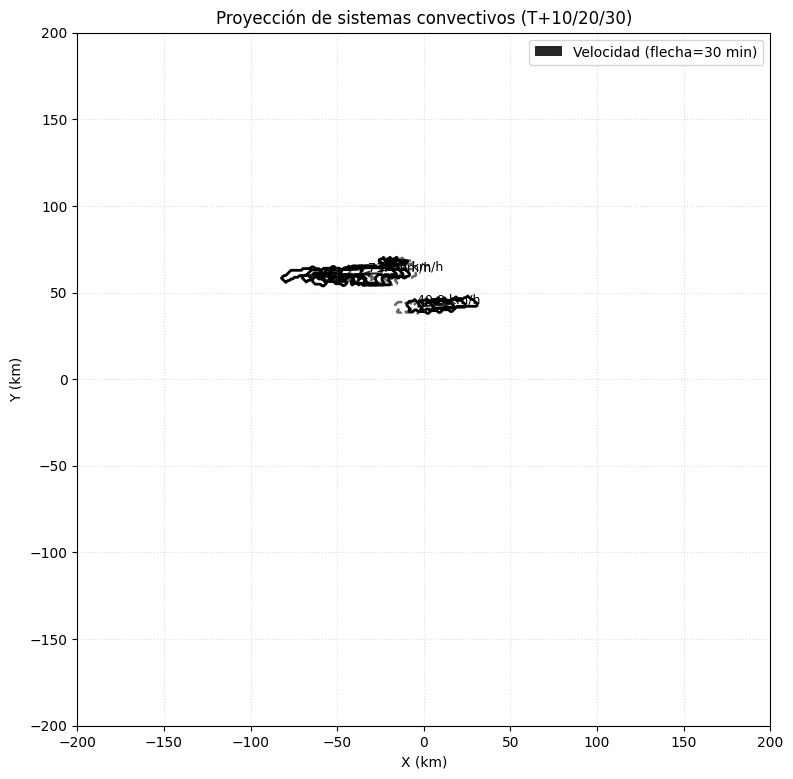

In [120]:
def plot_forecast_multi(
    systems_now,
    velocity_history,
    horizons_minutes=(10, 20, 30),
    extent_km=200,
    title="Proyección de sistemas (T+10/20/30)"
):
    import math
    import matplotlib.pyplot as plt
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Polygon as MplPolygon

    # --- helper interno: acepta shapely.Point o (x, y) ---
    def _xy_from_centroid(c):
        # shapely Point
        if hasattr(c, "x") and hasattr(c, "y"):
            return c.x, c.y
        # tupla/lista
        if isinstance(c, (tuple, list)) and len(c) == 2:
            return float(c[0]), float(c[1])
        raise ValueError("Centroide no reconocido (esperado shapely.Point o (x, y)).")

    fig, ax = plt.subplots(figsize=(9,9))

    # T0 actual
    patches_now = []
    for s in systems_now:
        geom = s.get("geometry")
        if geom is None or geom.is_empty:
            continue
        patches_now.append(MplPolygon(list(geom.exterior.coords), closed=True))
    if patches_now:
        pc_now = PatchCollection(
            patches_now, facecolor="none", edgecolor="0.4",
            linewidths=1.8, linestyles="--", label="T0 actual"
        )
        ax.add_collection(pc_now)

    # Para cada horizonte, pronosticar y dibujar
    for m in horizons_minutes:
        systems_fc = pronosticar_posiciones_etitan(
            systems_now, velocity_history, forecast_minutes=m
        )
        patches_fc = []
        for sf in systems_fc:
            geomf = sf.get("geometry")
            if geomf is None or geomf.is_empty:
                continue
            patches_fc.append(MplPolygon(list(geomf.exterior.coords), closed=True))
        if patches_fc:
            pc_fc = PatchCollection(
                patches_fc, facecolor="none", linewidths=2.0, label=f"T+{m} min"
            )
            ax.add_collection(pc_fc)

    # Flechas de velocidad desde T0
    if velocity_history:
        U, V, X, Y = [], [], [], []
        for s in systems_now:
            sid = s.get("id")
            if sid in velocity_history:
                vx, vy = velocity_history[sid]  # km/h
                cx, cy = _xy_from_centroid(s["centroid"])
                escala_min = 30.0  # flecha = desplazamiento en 30 min
                U.append(vx * (escala_min/60.0))
                V.append(vy * (escala_min/60.0))
                X.append(cx); Y.append(cy)
                speed = math.hypot(vx, vy)
                ax.text(cx, cy, f"{speed:.1f} km/h", fontsize=9, ha="left", va="bottom")
        if X:
            ax.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1.0,
                      width=0.003, alpha=0.85, label="Velocidad (flecha=30 min)")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-extent_km, extent_km)
    ax.set_ylim(-extent_km, extent_km)
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.show()

# === Llamada multi-horizonte ===
plot_forecast_multi(
    systems_now=systems_t2,
    velocity_history=velocity_history,
    horizons_minutes=(10, 20, 30),
    extent_km=200,
    title="Proyección de sistemas convectivos (T+10/20/30)"
)



In [117]:
def plot_forecast_multi_with_radar_base(
    systems_now,
    velocity_history,
    grid_now,                    # Py-ART Grid del tiempo T (ej: grid_current_2)
    field_name='DBZH',           # nombre del campo de reflectividad (p.ej. 'DBZH' o 'reflectivity')
    level=1,                     # nivel vertical a dibujar
    horizons_minutes=(10, 20, 30),
    vmin=0, vmax=60,             # escala dBZ
    extent_km=None,              # si None, se calcula desde la grilla
    title="Proyección de sistemas (radar base en T)"
):
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Polygon as MplPolygon

    # --- helper interno: acepta shapely.Point o (x, y) ---
    def _xy_from_centroid(c):
        if hasattr(c, "x") and hasattr(c, "y"):
            return float(c.x), float(c.y)
        if isinstance(c, (tuple, list)) and len(c) == 2:
            return float(c[0]), float(c[1])
        raise ValueError("Centroide no reconocido (esperado shapely.Point o (x, y)).")

    # ===== 1) RADAR BASE (grid_now) =====
    # Ejes X/Y en km
    x_km = grid_now.x["data"] / 1000.0  # 1D
    y_km = grid_now.y["data"] / 1000.0  # 1D
    X, Y = np.meshgrid(x_km, y_km)      # 2D

    # Campo de reflectividad en el nivel pedido
    # OJO: en Py-ART el orden suele ser [z, y, x]
    if field_name not in grid_now.fields:
        # fallback común
        alt_fields = [k for k in grid_now.fields.keys() if 'ref' in k.lower()]
        raise KeyError(f"No encontré '{field_name}' en grid_now.fields. Disponibles: "
                       f"{list(grid_now.fields.keys())} (posibles: {alt_fields})")
    Z = grid_now.fields[field_name]["data"][level, :, :]  # (y, x)
    Z = np.ma.masked_invalid(Z)

    # Extensión automática si no viene seteada
    if extent_km is None:
        max_abs = max(abs(x_km.min()), abs(x_km.max()), abs(y_km.min()), abs(y_km.max()))
        extent_km = float(np.ceil(max_abs))

    # Colormap (si tenés Py-ART, el de NWS queda muy bien)
    try:
        import pyart
        cmap = pyart.graph.cm.NWSRef
    except Exception:
        cmap = "viridis"

    fig, ax = plt.subplots(figsize=(9,9))

    # pcolormesh en coordenadas km, origen inferior
    pm = ax.pcolormesh(X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    cb = plt.colorbar(pm, ax=ax, pad=0.01)
    cb.set_label("Reflectividad (dBZ)")

    # ===== 2) CONTORNOS ACTUALES (T0 = systems_now) =====
    patches_now = []
    for s in systems_now:
        geom = s.get("geometry")
        if geom is None or geom.is_empty:
            continue
        patches_now.append(MplPolygon(list(geom.exterior.coords), closed=True))
    if patches_now:
        pc_now = PatchCollection(
            patches_now, facecolor="none", edgecolor="0.2",
            linewidths=1.8, linestyles="--", label="T0 actual"
        )
        ax.add_collection(pc_now)

    # ===== 3) PROYECCIONES MULTI-HORIZONTE =====
    for m in horizons_minutes:
        systems_fc = pronosticar_posiciones_etitan(systems_now, velocity_history, forecast_minutes=m)
        patches_fc = []
        for sf in systems_fc:
            geomf = sf.get("geometry")
            if geomf is None or geomf.is_empty:
                continue
            patches_fc.append(MplPolygon(list(geomf.exterior.coords), closed=True))
        if patches_fc:
            pc_fc = PatchCollection(
                patches_fc, facecolor="none", linewidths=2.0, label=f"T+{m} min"
            )
            ax.add_collection(pc_fc)

    # ===== 4) FLECHAS DE VELOCIDAD DESDE T0 =====
    if velocity_history:
        U, V, Xq, Yq = [], [], [], []
        for s in systems_now:
            sid = s.get("id")
            if sid in velocity_history:
                vx, vy = velocity_history[sid]  # km/h
                cx, cy = _xy_from_centroid(s["centroid"])
                escala_min = 30.0  # flecha = desplazamiento en 30 min
                U.append(vx * (escala_min/60.0))
                V.append(vy * (escala_min/60.0))
                Xq.append(cx); Yq.append(cy)
                speed = math.hypot(vx, vy)
                ax.text(cx, cy, f"{speed:.1f} km/h", fontsize=9, ha="left", va="bottom")
        if Xq:
            ax.quiver(Xq, Yq, U, V, angles="xy", scale_units="xy", scale=1.0,
                      width=0.003, alpha=0.9, label="Velocidad (flecha=30 min)")

    # ===== 5) AJUSTES FINALES =====
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-extent_km, extent_km)
    ax.set_ylim(-extent_km, extent_km)
    ax.grid(True, linestyle=":", alpha=0.35)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.show()

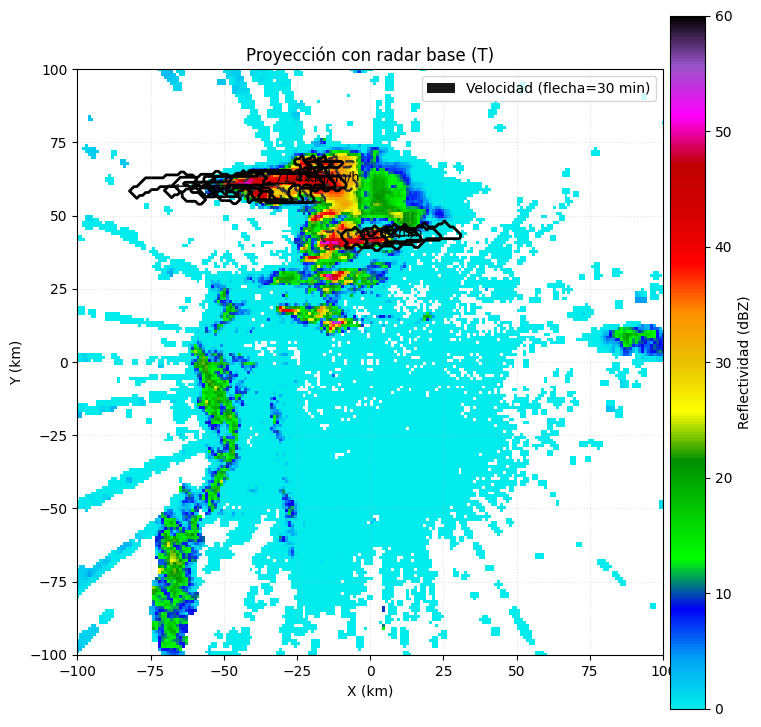

In [118]:
plot_forecast_multi_with_radar_base(
    systems_now=systems_t2,
    velocity_history=velocity_history,
    grid_now=grid_current_2,     # tu grilla Py-ART del tiempo T
    field_name='DBZH',           # cambia si tu field se llama distinto (p.ej. 'reflectivity')
    level=1,
    horizons_minutes=(10, 20, 30),
    vmin=0, vmax=60,
    extent_km=None,              # lo calcula de la grilla; o poné 200 para forzar ±200 km
    title="Proyección con radar base (T)"
)